## Contents:
https://www.kaggle.com/code/rkuo2000/mnist-vae#Visualizing-MNIST-with-a-Deep-Variational-Autoencoder
1. Introduction
2. Data Preparation
3. Model Construction
4. Training
5. Evaluation & Results

### 1. Introduction:
- **What is autoencoding?** <br>
Autoencoding is when a neural network learns to compress and then reconstruct its own input (the input and 'output' are essentially the same). Functions for compression and decompression are learned from the data. It's considered "semi-supervised" learning method since it's not entirely targetless; it learns the targets from the data itself.
Autoencoders are usually used in data preprocessing (as in denoising) or for dimensionality reduction. In fact, the hidden layers of simple autoencoders are doing something similar to PCA (principal component analysis), another method used for dimensionality reduction.

- **Autoencoders**
In general, they have 4 parts: encoder, bottleneck (latent space), decoder. It calculates  loss function, which measures reconstruction error - how much information was lost. In training, we use neural networks for encoder/decoder and optimize with gradient descent to minimize the loss, forcing the model to learn efficient data representations.

- **The Variational Variety**
There are bunch of different kinds of autoencoders, but here we talk about Variational Autoencoders. VAEs work differently than standard autoencoders: instead of turning the input into a fixed latent representation, VAEs encode it as a distribution that the data comes from. The encoder learns to map inputs to distribution parameters (mean & variance), and the decoder generates new data by sampling from this learned distribution. This makes VAEs generative models that can create new, similar data, rather than just reconstructing inputs. 

## 2. Data Preparation

In [1]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import norm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms

torch.manual_seed(237)
np.random.seed(237)

In [3]:
transform = transforms.ToTensor()
# Automatically: 
# - Converts to float32 tensor 
# - Scales 0-255 → 0.0-1.0
# - Reshapes to (1,28,28) [channels_first]

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]


In [4]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

We can take a look at a few random images. The bottom right panel shows one of the more difficult-to-classify digits (even for humans!).

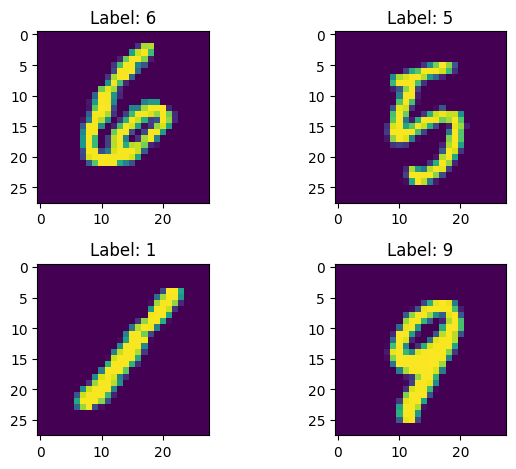

In [5]:
plt.figure(1)

plt.subplot(221)
plt.imshow(train_dataset[13][0].squeeze())
plt.title(f"Label: {train_dataset[13][1]}") 

plt.subplot(222)
plt.imshow(train_dataset[690][0].squeeze())
plt.title(f"Label: {train_dataset[690][1]}") 

plt.subplot(223)
plt.imshow(train_dataset[2375][0].squeeze())
plt.title(f"Label: {train_dataset[2375][1]}") 

plt.subplot(224)
plt.imshow(train_dataset[42013][0].squeeze())
plt.title(f"Label: {train_dataset[42013][1]}") 

plt.tight_layout()

## 3. Model Construction

### 3.1. Encoder network: 

In [6]:
img_shape = (1, 28, 28)   # for MNIST

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),      # padding=1 keeps same size
            nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(), # stride=2 halves dimensions (28/2=14)
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.dense = nn.Linear(64 * 14 * 14, 32)  # 14 due to stride=2
        self.relu = nn.ReLU()

        self.z_mu = nn.Linear(32, latent_dim)
        self.z_log_sigma = nn.Linear(32, latent_dim)

        self.shape_before_flattening = (64, 14, 14)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.relu(self.dense(x))

        # two output values:
        z_mu = self.z_mu(x)
        z_log_sigma =  self.z_log_sigma(x)

        return z_mu, z_log_sigma, self.shape_before_flattening

### 3.2. Sampling Function

The sampling function uses the **reparameterization trick** to enable gradient-based training of the VAE. Instead of directly sampling from the learned distribution N(μ, σ²) - which would block gradient flow - it first samples from a standard normal distribution N(0,1) and then shifts and scales these samples using the learned parameters. Specifically, it computes z = μ + exp(σ) × ε, where ε is random noise from N(0,1). This formulation allows gradients to flow through the deterministic parameters μ and σ while treating the randomness ε as an external input, making the entire model trainable with backpropagation.

In [8]:
def sampling(z_mu, z_log_sigma ):
    epsilon = torch.randn_like(z_mu)    # automatically matches thes shape of given arg - z_mu
    return z_mu + torch.exp(z_log_sigma) * epsilon 

### 3.3. Decoder Network
The decoder is basically the encoder in reverse. <br>
The decoder takes the latent distribution sample as input.


In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, shape_before_flattening):         
        super().__init__()

        self.shape_before_flattening = shape_before_flattening
        
        self.dense = nn.Linear(latent_dim, np.prod(shape_before_flattening))  # Back to flattened size 64*14*14
        self.relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, shape_before_flattening)

        self.conv_layers = nn.Sequential (
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()          # Output pixels between 0-1
        )

    def forward(self, z):
        x = self.relu(self.dense(z))
        x = self.reshape(x)    # Reshape to (64,14,14)
        x = self.conv_layers(x)
        
        return x

### 3.4. Loss
VAE is trained using a loss function with two components:
1. 'Reconstruction loss' - this is the cross entropy describing the loss between reconstructed samples from latent distribution and the original samples
2. Kullback-Liebler divergence between the latent distribution and the prior (this acts as a regularization term)

In [10]:
def vae_loss(x, reconstruction, z_mu, z_log_sigma, beta=0.0001):
    x_flat = x.view(x.size(0), -1)    # Flatten images: (batch,1,28,28) → (batch,784)
    recon_flat = reconstruction.view(reconstruction.size(0), -1)

    reconstruction_loss = nn.functional.binary_cross_entropy(recon_flat, x_flat, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + z_log_sigma - z_mu.pow(2) - z_log_sigma.exp())

    # print(f"reconstruction loss = {reconstruction_loss.item()}")
    # print(f"KL loss = {kl_loss.item()}")
    
    return reconstruction_loss + beta*kl_loss

### 3.5. VAE (putting it all together)

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, input_shape=(1, 28, 28)):
        super().__init__()
        self.encoder = Encoder(latent_dim)

        # Get shape by passing dummy input through encoder
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_shape)
            _, _, shape_before_flattening = self.encoder(dummy_input)
        
        self.decoder = Decoder(latent_dim, shape_before_flattening)

    def forward(self, x):
        z_mu, z_log_sigma, _ = self.encoder(x)
        z = sampling(z_mu, z_log_sigma)
        reconstruction = self.decoder(z)
        return reconstruction, z_mu, z_log_sigma

## 4. Training

In [12]:
latent_dim = 32
epochs = 3
lr = 0.0001

vae_model = VAE(latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=lr)

In [13]:
def train_vae(model, epochs, train_dataloader, optimizer):
    model.train()    # sets to training mode

    for epoch in range(epochs):
        total_loss = 0
        print(f"Starting epoch {epoch+1}")  
        for batch_idx, (data, _) in enumerate(train_dataloader):
            optimizer.zero_grad()

            reconstruction, z_mu, z_log_sigma = model(data)

            loss = vae_loss(data, reconstruction, z_mu, z_log_sigma)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        avg_loss = total_loss/ len(train_dataloader.dataset)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f} ")

In [14]:
train_vae(vae_model, epochs, train_dataloader, optimizer)

Starting epoch 1
Epoch 1 completed. Average Loss: 0.0125 
Starting epoch 2
Epoch 2 completed. Average Loss: 0.0079 
Starting epoch 3
Epoch 3 completed. Average Loss: 0.0073 


## 5. Evaluation & Results

In [15]:
def evaluate_vae(model, dataloader):
    model.eval()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(dataloader):
            batch_size = data.size(0)
            reconstructed, z_mu, z_logsigma = model(data)

            batch_loss = vae_loss(data, reconstructed, z_mu, z_logsigma)

            total_loss += batch_loss.item() * batch_size
            total_samples += batch_size
            
    avg_loss = total_loss/total_samples
    return {
        'avg_total_loss': avg_loss,
        'total_samples': total_samples}

In [16]:
metrics = evaluate_vae(vae_model, test_dataloader)
print(f"Average loss for model of latent_dim={latent_dim}, epochs={epochs}, on test set: {metrics['avg_total_loss']:.4f}")

Average loss for model of latent_dim=32, epochs=3, on test set: 0.1136


In [30]:
def plot_test_idx(model, test_data, example_index=0):
    model.eval()
    
    test_image, test_label = test_data[example_index]  # Use your test_dataset
    test_image = test_image.unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        reconstruction, _, _ = model(test_image)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image[0].squeeze(), cmap='gray')
    plt.title(f"Original Image (Label: {test_label})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction[0].squeeze(), cmap='gray')
    plt.title("VAE Reconstruction")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

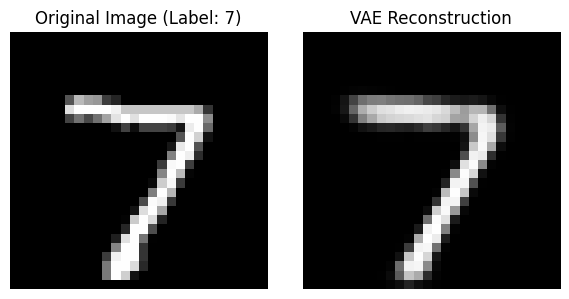

In [31]:
plot_test_idx(vae_model, test_dataset, 0)

**pretty good!**

Let's see what happens if we set parameters differently when training our model:

In [19]:
latent_dim_2 = 2
epochs_2 = 3
lr_2 = 0.0001

vae_model_2 = VAE(latent_dim=latent_dim_2)
optimizer_2 = torch.optim.Adam(vae_model_2.parameters(), lr=lr_2)

train_vae(vae_model_2, epochs_2, train_dataloader, optimizer_2)

Starting epoch 1
Epoch 1 completed. Average Loss: 0.0147 
Starting epoch 2
Epoch 2 completed. Average Loss: 0.0104 
Starting epoch 3
Epoch 3 completed. Average Loss: 0.0093 


In [20]:
metrics_2 = evaluate_vae(vae_model_2, test_dataloader)
print(f"Average loss for model of latent_dim={latent_dim_2},  epochs={epochs_2}, on test set: {metrics_2['avg_total_loss']:.4f}")

Average loss for model of latent_dim=32,  epochs=3, on test set: 0.1446


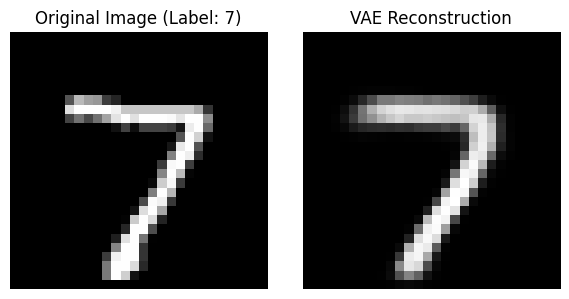

In [32]:
plot_test_idx(vae_model_2, test_dataset, 0)

In [22]:
latent_dim_3 = 2
epochs_3 = 3
lr_3 = 0.001

vae_model_3 = VAE(latent_dim_3)
optimizer_3 = torch.optim.Adam(vae_model_3.parameters(), lr=lr_3)

train_vae(vae_model_3, epochs_3, train_dataloader, optimizer_3)

Starting epoch 1
Epoch 1 completed. Average Loss: 0.0167 
Starting epoch 2
Epoch 2 completed. Average Loss: 0.0165 
Starting epoch 3
Epoch 3 completed. Average Loss: 0.0164 


In [23]:
metrics_3 = evaluate_vae(vae_model_3, test_dataloader)
print(f"Average loss for model of latent_dim={latent_dim_3}, epochs={epochs_3}, on test set: {metrics_3['avg_total_loss']:.4f}")

Average loss for model of latent_dim=2, epochs=3, on test set: 0.2633


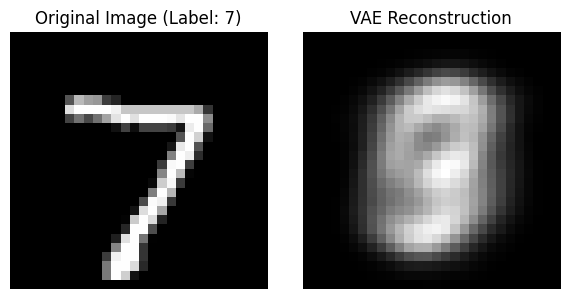

In [34]:
plot_test_idx(vae_model_3, test_dataset, 0)

We can conclude that we get much a bit clearer results for higher latent space dimension. However, the average loss is obviously better when the larning rate is kept smaller. 

Now we want to visualize how we sample from the latent space by varying only two dimensions while keeping the rest of them fixed. In case of more dimensions (e.g. 32) the 2D slice shows limited meaningful structure since most dimensions remain at zero.

In [35]:
def plot_latent_grid(model, dim1=0, dim2=1, n=10, latent_dim=2, range_val=(-5, 5)):
    figure = np.zeros((28 * n, 28 * n))
    grid = np.linspace(range_val[0], range_val[1], n)
    
    model.eval()
    with torch.no_grad():
        for i, y_val in enumerate(grid):
            for j, x_val in enumerate(grid):
                z = torch.zeros(1, latent_dim)
                z[0, dim1] = x_val
                z[0, dim2] = y_val
                
                digit = model.decoder(z).squeeze().cpu().numpy()
                figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.axis('off')
    plt.show()

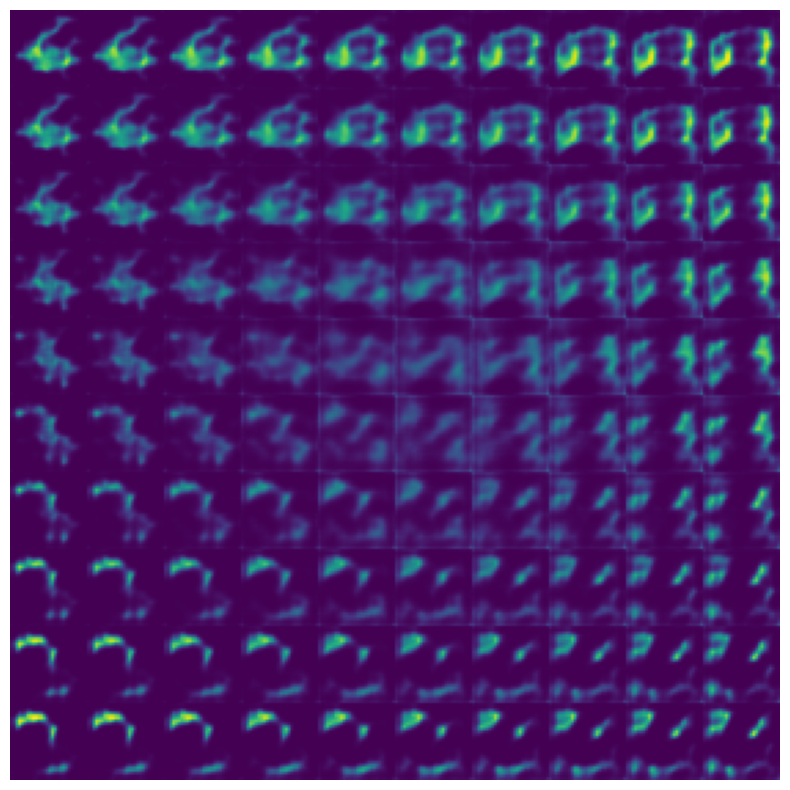

In [44]:
plot_latent_grid(vae_model, dim1=0, dim2=2, n=10, range_val=(-5, 5), latent_dim=latent_dim)

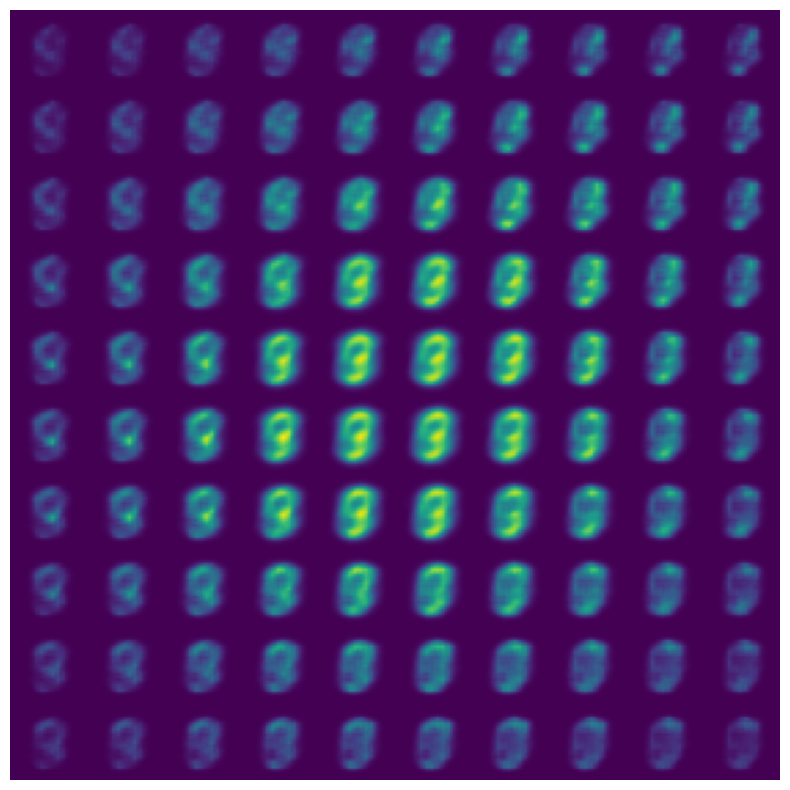

In [50]:
plot_latent_grid(vae_model_3, dim1=0, dim2=1, n=10, range_val=(-5, 5), latent_dim = latent_dim_3)

Here, we can see that our third model just learnt the same shape. Probably because of the too big learning rate. 